<a href="https://colab.research.google.com/github/basagliuz/Tirocinio/blob/main/Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 2

Signal in colored, gaussian noise.

Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
The data contain a BBH signal with m1 = m2 = 30 solar masses, spin = 0.

In [1]:
# Run once, then click "restart session" in the runtime menu and run again

! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

# Download data
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge2.gwf
from gwpy.timeseries import TimeSeries
from pycbc import frame
gwpy_data = TimeSeries.read('challenge2.gwf', channel = "H1:CHALLENGE2")
pycbc_data = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

--2024-09-01 16:03:34--  https://dcc.ligo.org/public/0187/G2300818/001/challenge2.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025853 (3.8M)
Saving to: ‘challenge2.gwf.12’

challenge2.gwf.12   100%[===================>]   3.84M  --.-KB/s    in 0.09s   

2024-09-01 16:03:35 (42.5 MB/s) - ‘challenge2.gwf.12’ saved [4025853/4025853]



/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


# First quesion
What is the approximative time of the merger? \
(Hint: a plot of the q-transform could help)

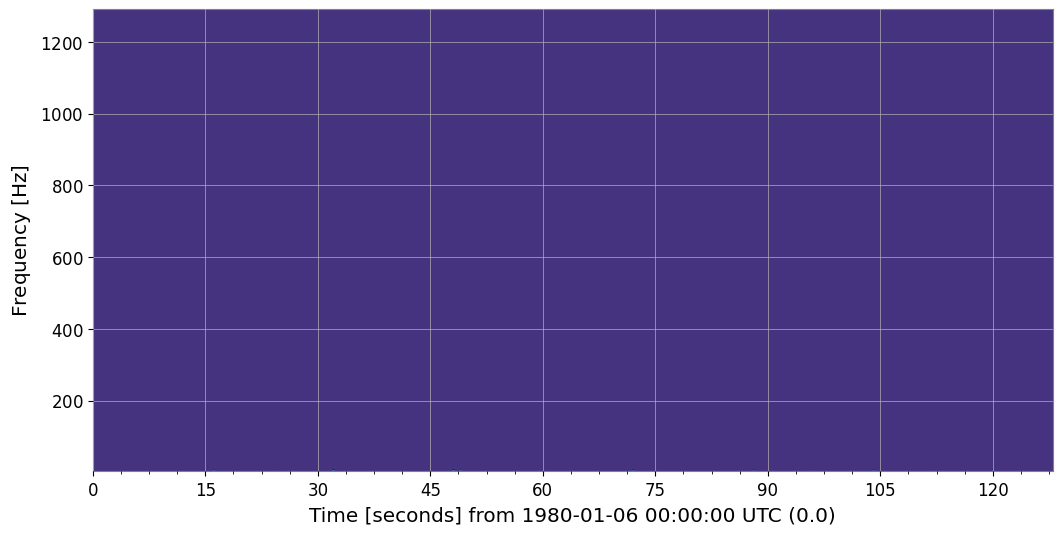

In [2]:
# Let's try a plain q-transform first
plot = gwpy_data.q_transform().plot()

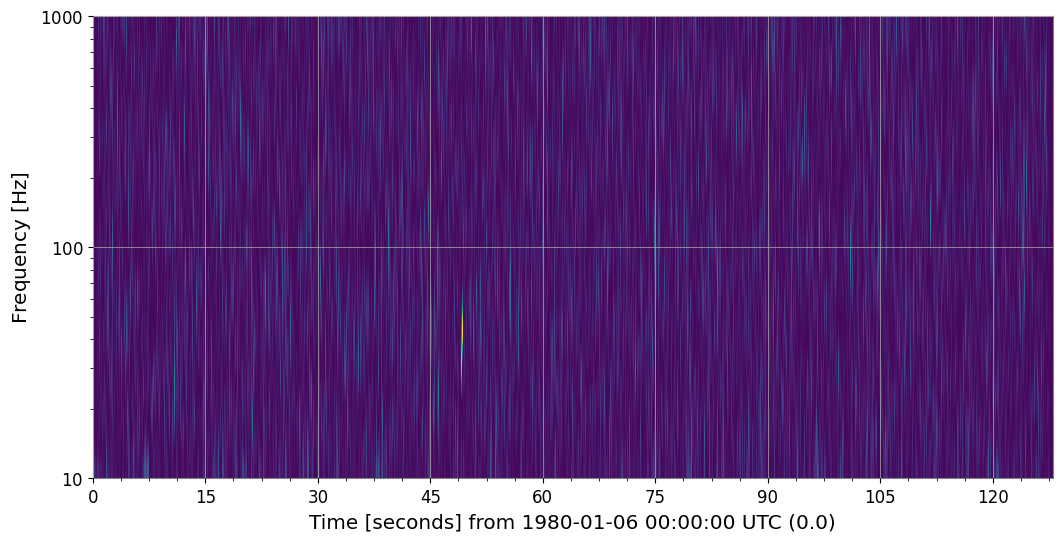

In [3]:
# We need to narrow the frequency range
plot = gwpy_data.q_transform(frange = (10, 1000)).plot(yscale = 'log')

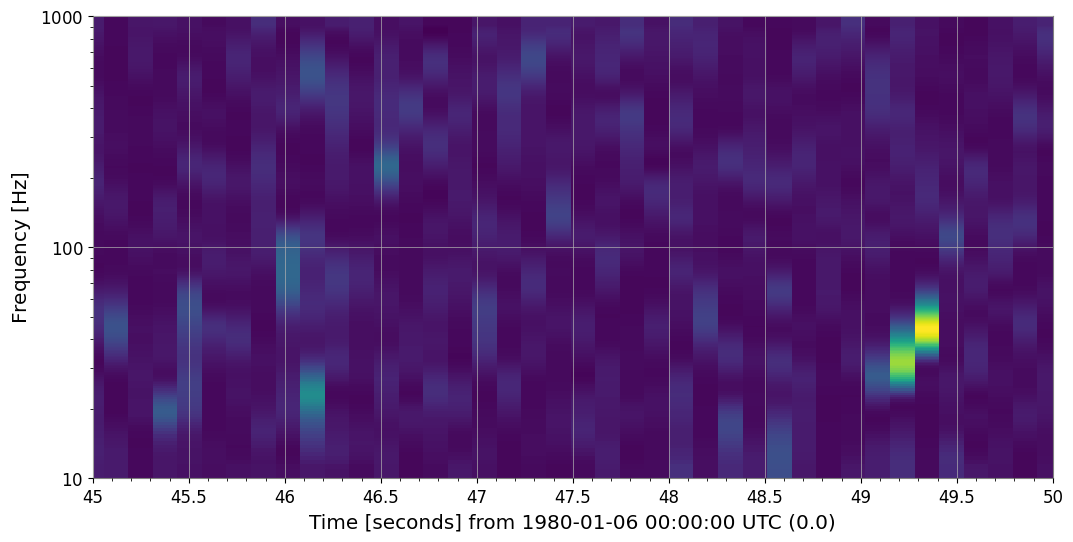

In [4]:
# We can see some kind of signal between 45 s and 50 s.
plot = gwpy_data.q_transform(frange = (10, 1000)).plot(xlim = (45, 50), yscale = 'log', epoch = 0)

The approximate time of the merger is 49.3 s.

# Second question
Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.

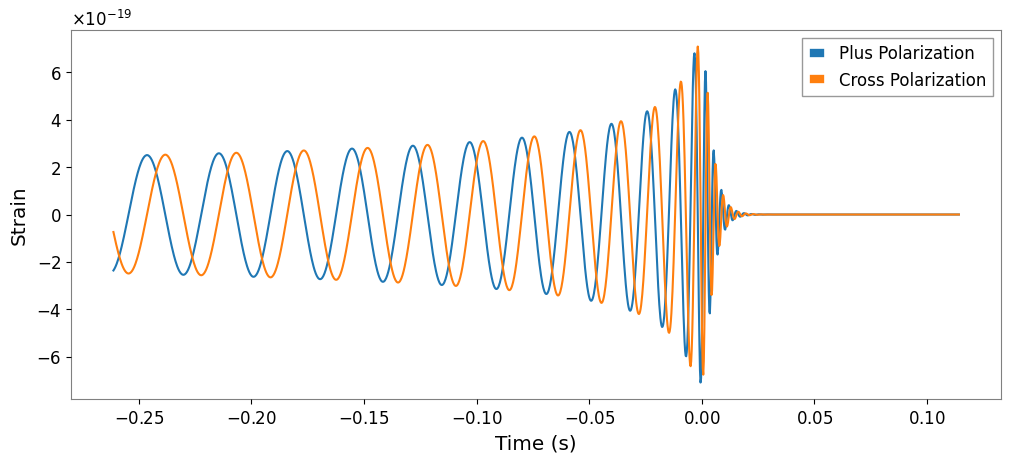

In [5]:
# Installing what we need to generate the waveform
from pycbc.waveform import get_td_waveform
import pylab

# Generating waveform
hp, hc = get_td_waveform(approximant = 'SEOBNRv4_opt',
                         mass1 = 30,
                         mass2 = 30,
                         delta_t = 1.0/4096,
                         f_lower = 30)

# Plotting waveform
pylab.figure(figsize = pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label = 'Plus Polarization')
pylab.plot(hp.sample_times, hc, label = 'Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Third question
Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 hz up to the Nyquist frequency.

In [6]:
# Preconditioning data
from pycbc.filter import highpass
pycbc_data = highpass(pycbc_data, 15)
pycbc_data = pycbc_data.crop(2, 2)

The Nyquist frequency is 2048.0 hz.


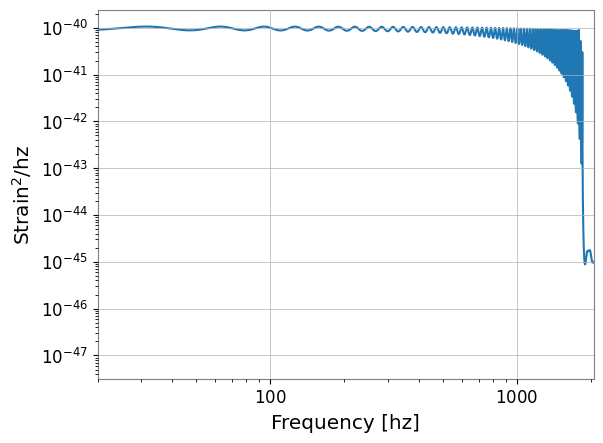

In [7]:
# Evaluetaing PSD
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = pycbc_data.psd(4)
psd = interpolate(psd, pycbc_data.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_data.sample_rate), low_frequency_cutoff = 15)

# Evalueating Nyquist frequency
fn = pycbc_data.sample_rate / 2
print('The Nyquist frequency is {} hz.'.format(fn))

# Plotting the data
pylab.plot(psd)
pylab.xscale('log')
pylab.xlabel('Frequency [hz]')
pylab.xlim(20, fn)
pylab.yscale('log')
pylab.ylabel('Strain$^2$/hz')
pylab.show()

# Fourth question
Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

In [8]:
# Resizing and shifting our model
hp.resize(len(pycbc_data))
hp = hp.cyclic_time_shift(hp.start_time)

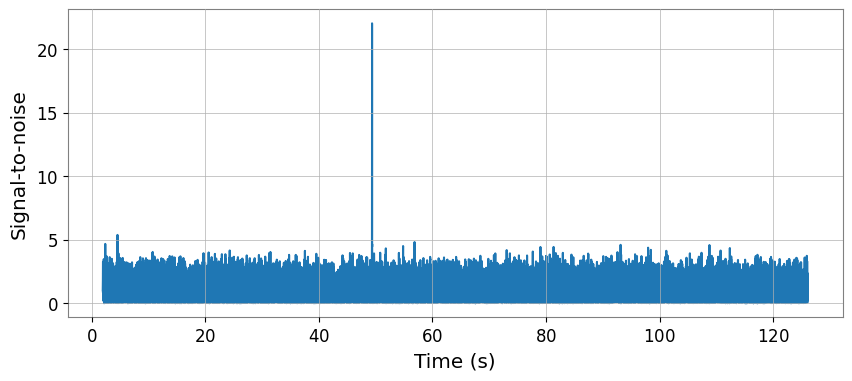

In [9]:
# Generating SNR from the PSD and our model (hp)
from pycbc.filter import matched_filter
import numpy
model = hp
data = pycbc_data
snr = matched_filter(model, data, psd = psd, low_frequency_cutoff = 15)

# Plotting the SNR
pylab.figure(figsize = [10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

# Fifth question
What is the matched filter SNR of the signal?

In [10]:
# Where is the peak? What is its SNR?
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a peak at {} s with SNR {}.".format(time, abs(snrp)))

We found a peak at 49.3671875 s with SNR 22.02675738434501.
